## Assignment 2
### Implement the following 
 - Policy evaluation and Policy Improvement
 - Value and Policy Iteration
 - Bellman Equations

## Gridworld City
Gridworld City, a thriving metropolis with a booming technology industry, has recently experienced an influx of grid-loving software engineers. Unfortunately, the city's street parking system, which charges a fixed rate, is struggling to keep up with the increased demand. To address this, the city council has decided to modify the pricing scheme to better promote social welfare. In general, the city considers social welfare higher when more parking is being used, the exception being that the city prefers that at least one spot is left unoccupied (so that it is available in case someone really needs it). The city council has created a Markov decision process (MDP) to model the demand for parking with a reward function that reflects its preferences. Now the city has hired you — an expert in dynamic programming — to help determine an optimal policy.

In [1]:
%%capture
%matplotlib inline
import numpy as np
import pickle
import tools

In the city council's parking MDP
 - states are nonnegative integers indicating number of parking spots left 
 - actions are nonnegative integers designating the price of street parking
 - rewards are real values describing the city's preference 
 
Consider an environment with three parking spaces and three price points

In [2]:
num_spaces = 3
num_prices = 3
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
pi = np.ones((num_spaces+1, num_prices)) / num_prices #number of states = number of spaces + 1; zero, one, two or three spaces occupied

In [3]:
V

array([0., 0., 0., 0.])

In [4]:


state = 0
V[state]



0.0

In [5]:
state = 0
value = 10
V[state] = value
V

array([10.,  0.,  0.,  0.])

In [6]:
for s, v in enumerate(V):
    print(f'State {s} has value {v}')

State 0 has value 10.0
State 1 has value 0.0
State 2 has value 0.0
State 3 has value 0.0


In [7]:
pi

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [8]:
state = 0
pi[state]

array([0.33333333, 0.33333333, 0.33333333])

In [9]:
state = 0
action = 1
pi[state, action]

0.3333333333333333

In [10]:
pi[state] = np.array([0.75, 0.21, 0.04])
pi

array([[0.75      , 0.21      , 0.04      ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [11]:
for s, pi_s in enumerate(pi):
    print(f''.join(f'pi(A={a}|S={s}) = {p.round(2)}' + 4 * ' ' for a, p in enumerate(pi_s)))

pi(A=0|S=0) = 0.75    pi(A=1|S=0) = 0.21    pi(A=2|S=0) = 0.04    
pi(A=0|S=1) = 0.33    pi(A=1|S=1) = 0.33    pi(A=2|S=1) = 0.33    
pi(A=0|S=2) = 0.33    pi(A=1|S=2) = 0.33    pi(A=2|S=2) = 0.33    
pi(A=0|S=3) = 0.33    pi(A=1|S=3) = 0.33    pi(A=2|S=3) = 0.33    


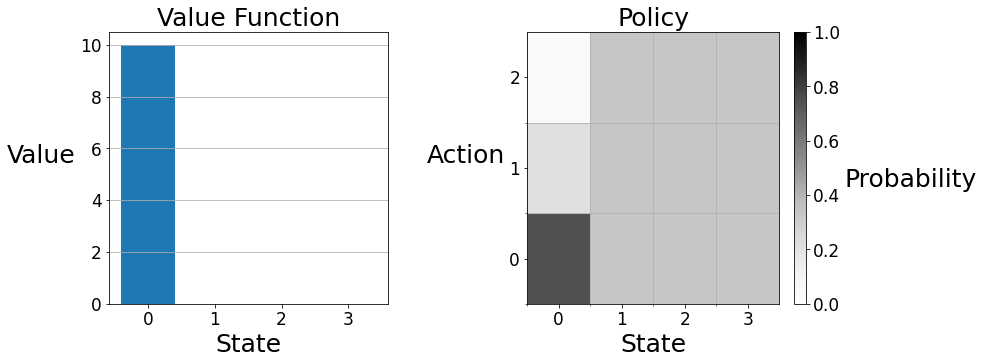

In [12]:
tools.plot(V, pi)

In [13]:
env.S

[0, 1, 2, 3]

In [14]:
env.A

[0, 1, 2]

The transitions method takes a state and an action and returns a 2-dimensional array, where the entry at $(i, 0)$ is the reward for transitioning to state $i$ from the current state and the entry at $(i, 1)$ is the conditional probability of transitioning to state $i$ given the current state and action.

In [15]:
state = 3
action = 1
transitions = env.transitions(state, action)
transitions

array([[1.        , 0.12390437],
       [2.        , 0.15133714],
       [3.        , 0.1848436 ],
       [2.        , 0.53991488]])

In [16]:
for s_, (r, p) in enumerate(transitions):
    print(f'p(S\'={s_}, R={r} | S={state}, A={action}) = {p.round(2)}')

p(S'=0, R=1.0 | S=3, A=1) = 0.12
p(S'=1, R=2.0 | S=3, A=1) = 0.15
p(S'=2, R=3.0 | S=3, A=1) = 0.18
p(S'=3, R=2.0 | S=3, A=1) = 0.54


## Section 1: Policy Evaluation


In [17]:
def evaluate_policy(env, V, pi, gamma, theta):
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v-V[s]))
        if delta < theta:
            break
    return V

In [18]:
def bellman_update(env, V, pi, s, gamma):
    """Mutate ``V`` according to the Bellman update equation."""
    v = 0
    for action in env.A:
        action_prob = pi[s][action]
        transitions = env.transitions(s, action)
        for next_state in env.S:
            reward = transitions[next_state, 0]
            prob = transitions[next_state, 1]
            v += action_prob * prob * (reward+ gamma * V[next_state])
    V[s] = v

In [19]:
num_spaces = 10
num_prices = 4
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1
gamma = 0.9
theta = 0.1
V = evaluate_policy(env, V, city_policy, gamma, theta)

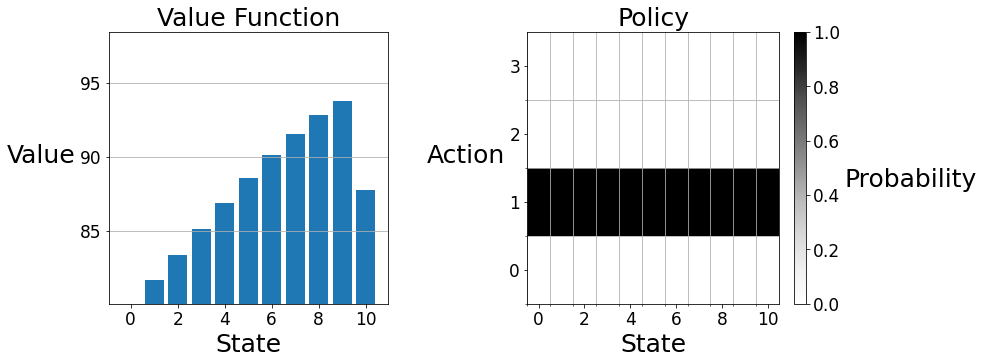

In [20]:
tools.plot(V, city_policy)

In [21]:
with open('section1', 'rb') as handle:
    V_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)

## Section 2: Policy Iteration

In [27]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old):
            policy_stable = False
    return pi, policy_stable

In [28]:
def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
    return V, pi

In [29]:
def q_greedify_policy(env, V, pi, s, gamma):
    """Mutate ``pi`` to be greedy with respect to the q-values induced by ``V``."""
    A = np.zeros(len(env.A))
    for action in env.A:
        transitions = env.transitions(s, action)
        for next_state in env.S:
            reward = transitions[next_state, 0]
            prob = transitions[next_state, 1]
            A[action] += prob * (reward + gamma * V[next_state])
    best_action = np.argmax(A)
    pi[s] = np.eye(len(env.A))[best_action]

In [30]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)

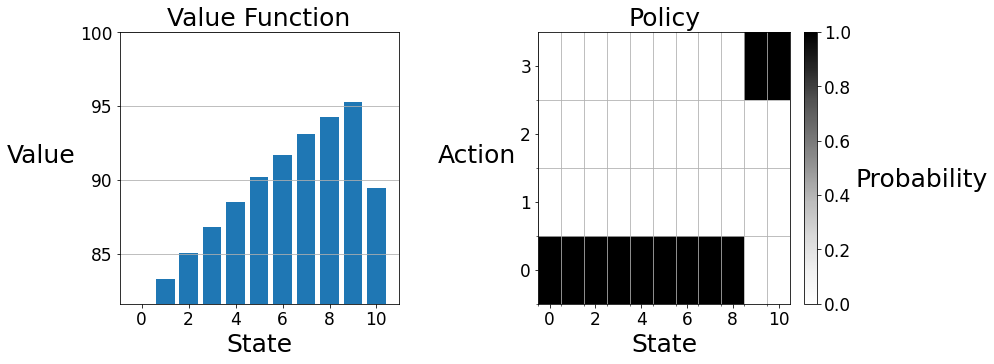

In [31]:
tools.plot(V, pi)